## 13.4. Pillow를 활용한 데이터 전처리

In [1]:
import os
import pickle
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))
#print(train)   # 혹시 내용이 궁금하다면 주석을 풀고 실행해 보세요.


<class 'dict'>


## 13.7. 실습 : 비슷한 이미지 찾아내기

In [2]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

# 전처리 시 생성했던 디렉토리 구조
dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/'
train_file_path = os.path.join(dir_path, 'train')
images_dir_path = os.path.join(dir_path, 'cifar-images')

In [3]:
# 파일명을 인자로 받아 해당 이미지 파일과 히스토그램을 출력해 주는 함수
def draw_color_histogram_from_image(file_name):
    image_path = os.path.join(images_dir_path, file_name)
    # 이미지 열기
    img = Image.open(image_path)
    cv_image = cv2.imread(image_path)

    # Image와 Histogram 그려보기
    f=plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256])   
        im2.plot(histr,color = col)   # 그래프를 그릴 때 채널 색상과 맞춰서 그립니다.
    im2.set_title("Histogram")

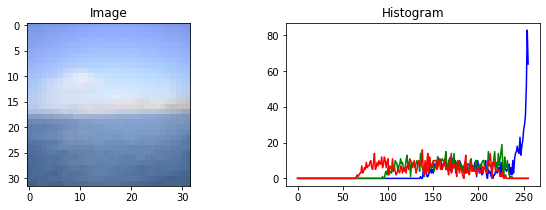

In [6]:
draw_color_histogram_from_image('adriatic_s_001807.png')

In [7]:
def get_histogram(image):
    histogram = []

    # Create histograms per channels, in 4 bins each.
    for i in range(3):
        channel_histogram = cv2.calcHist(images=[image],
                                         channels=[i],
                                         mask=None,
                                         histSize=[4],  # 히스토그램 구간을 4개로 한다.
                                         ranges=[0, 256])
        histogram.append(channel_histogram)  

    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)

    return histogram


In [8]:
# get_histogram() 확인용 코드
filename = train[b'filenames'][0].decode()
file_path = os.path.join(images_dir_path, filename)
image = cv2.imread(file_path)
histogram = get_histogram(image)
histogram

array([[0.3126804 ],
       [0.4080744 ],
       [0.14521089],
       [0.21940625],
       [0.18654831],
       [0.23742512],
       [0.30208108],
       [0.35931748],
       [0.06465594],
       [0.35825753],
       [0.36991683],
       [0.29254165]], dtype=float32)

In [9]:
def build_histogram_db():
    histogram_db = {}

    #디렉토리에 모아 둔 이미지 파일들을 전부 리스트업합니다. 
    path = images_dir_path
    file_list = os.listdir(images_dir_path)

    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db

In [10]:
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png']

100%|██████████| 49999/49999 [00:07<00:00, 6638.13it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [11]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요: ")
    if filename not in histogram_db:
        print('유효하지 않은 이미지 파일명입니다.')
        return None
    return histogram_db[filename]

In [12]:
target_histogram = get_target_histogram()
target_histogram

이미지 파일명을 입력하세요: adriatic_s_001807.png


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [13]:
def search(histogram_db, target_histogram, top_k=5):
    results = {}

    # Calculate similarity distance by comparing histograms.
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1=target_histogram,
                                   H2=histogram,
                                   method=cv2.HISTCMP_CHISQR)

        results[file_name] = distance

    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

    return results


In [14]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 408192.63it/s]


{'adriatic_s_001807.png': 0.0,
 'baby_s_001654.png': 0.047506706444185816,
 'fogbank_s_000423.png': 0.059270738493642845,
 'tank_s_000442.png': 0.060966690827361725,
 'dessert_plate_s_000124.png': 0.06113711905561663}

In [15]:
def show_result(result):
    f=plt.figure(figsize=(10,3))
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        im = f.add_subplot(1,len(result),idx+1)
        img = Image.open(img_path)
        im.imshow(img)

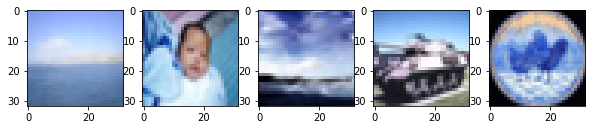

In [16]:
show_result(result)

In [ ]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)